In [1]:
import obspy as op
import numpy as np
import cartopy.crs as ccrs
from obspy.clients.fdsn import Client
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import datetime

In [2]:
#pull all earthquakes from the last 10 years to make initial data set
currentDT = datetime.datetime.now()
print ('Download initiated. Usually takes around 2 minutes')
print ('Download began: ',str(currentDT))

client = Client("IRIS")
t1 = op.UTCDateTime("2011-01-01T00:00:00") #start time of the request
t2 = op.UTCDateTime("2021-10-27T00:00:00") #end time of the request
minMag = 5.0

catalog = client.get_events(starttime=t1, endtime=t2, minmagnitude=minMag)

currentDT = datetime.datetime.now()
print ('Download ended: ',str(currentDT))

Download initiated. Usually takes around 2 minutes
Download began:  2021-11-30 15:10:44.250956
Download ended:  2021-11-30 15:12:17.039242


In [3]:
# print the number of EQ and print info of the most recent one (has index=0)
print(len(catalog.events))
print(catalog[0].origins[0].latitude,catalog[0].origins[0].longitude)
print(catalog[0].origins[0].time)
print(catalog[0].magnitudes[0].mag)

21031
-59.4116 -24.9465
2021-10-26T08:44:20.124000Z
5.0


In [4]:
# copy latitude, longitude, depth, and magnitude out of the catalog so that they can be plotted
evlat =[]
evlon =[]
evdep =[]
evmag = []
index = 0

for eve in catalog:
    event = catalog[index]
    org = event.origins
    evlat.append(org[0].latitude)
    evlon.append(org[0].longitude)
    #print(org[0].depth)
    if (org[0].depth==None):
        evdep.append(0.0)
    else:
        evdep.append((org[0].depth) / 1000.0)
    evmag.append((event.magnitudes[0].mag)**4/2)
    index+=1

In [5]:
#defining a distance function with lat and lon inputs.

def dist (x0,y0,x1,y1):
    R=6378
    diffLat=R*(x1-x0)*np.pi / 180
    diffLong=(R*np.cos(x1*np.pi / 180) * y1 * np.pi / 180) - (R*np.cos(x0*np.pi / 180) * y0 * np.pi / 180)

    distance=(np.sqrt(diffLat**2 + diffLong**2))
    return distance

In [6]:
#extracting indecices of earthquakes that occur <10km from each other. 
currentDT = datetime.datetime.now()
print ('begins: ',str(currentDT),', usually takes around 15min')
keep=[]
for event in range (len(evlat)):
    first=0
    #print(event,'event')
    if event not in keep:
        #check if the earthquake index has already been checked and stored
        x0=evlat[event]
        y0=evlon[event]
        for ind in range (event+1, len(evlat)):
            #print(ind,'ind',dis,'distance',keep,'keep')
            dis=dist(x0,y0,evlat[ind],evlon[ind])
            #print(first==0)
            if dis < 20 and first==0:
                keep.append(event)
                keep.append(ind)
                first=1
            elif dis<20 and first !=0:
                keep.append(ind)
currentDT = datetime.datetime.now()
print ('ended: ',str(currentDT))

begins:  2021-11-30 15:12:48.283966 , usually takes around 15min
ended:  2021-11-30 15:25:16.390146


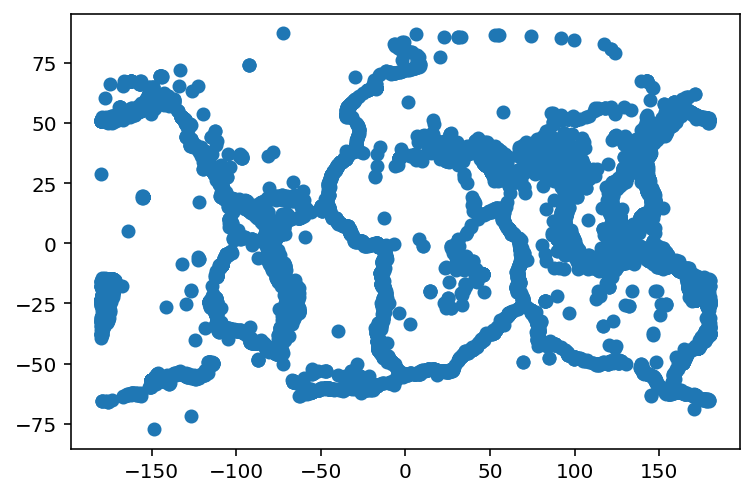

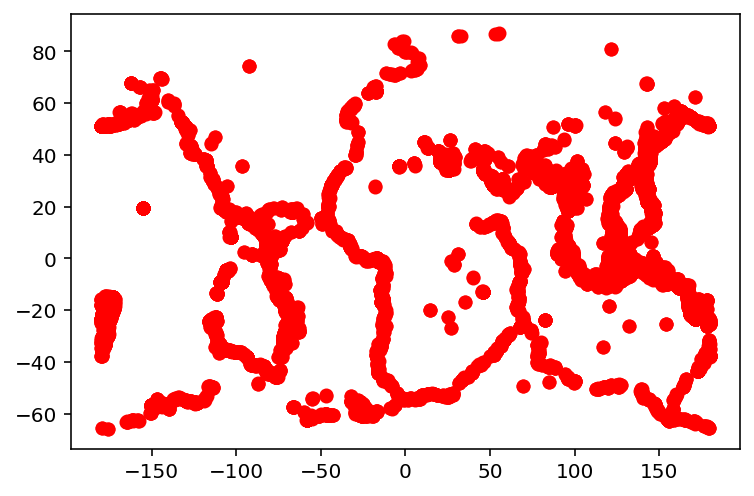

In [7]:
#plotting the kept earthquakes
indexes=np.abs([x for x in keep])
#print(indexes)
plt.plot(evlon,evlat,'o')
plt.show()
for index in range (len(indexes)):
    #print(keep[index])
    plt.plot(evlon[np.abs(keep[index])],evlat[np.abs(keep[index])],'ro')

#plt.plot(evlat[2],evlon[2],'go')
#plt.plot(evlat[19],evlon[19],'go')

plt.show()

20413


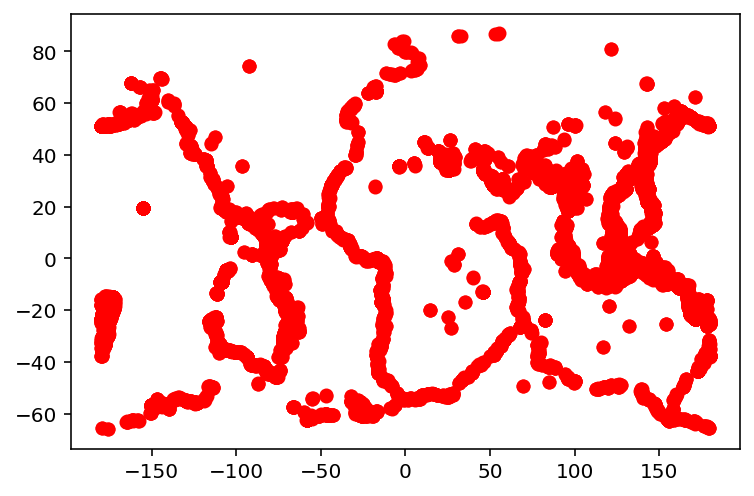

In [8]:
#getting lists of lats and lons from the keep list of indexes.
indexes=np.abs([x for x in keep])
keepLat=[]
keepLon=[]
for index in range (len(indexes)):
 
    keepLat.append(evlat[np.abs(keep[index])])
    keepLon.append(evlon[np.abs(keep[index])])                     
    
print(len(keepLat))
#plotting to check
plt.plot(keepLon,keepLat,'ro')

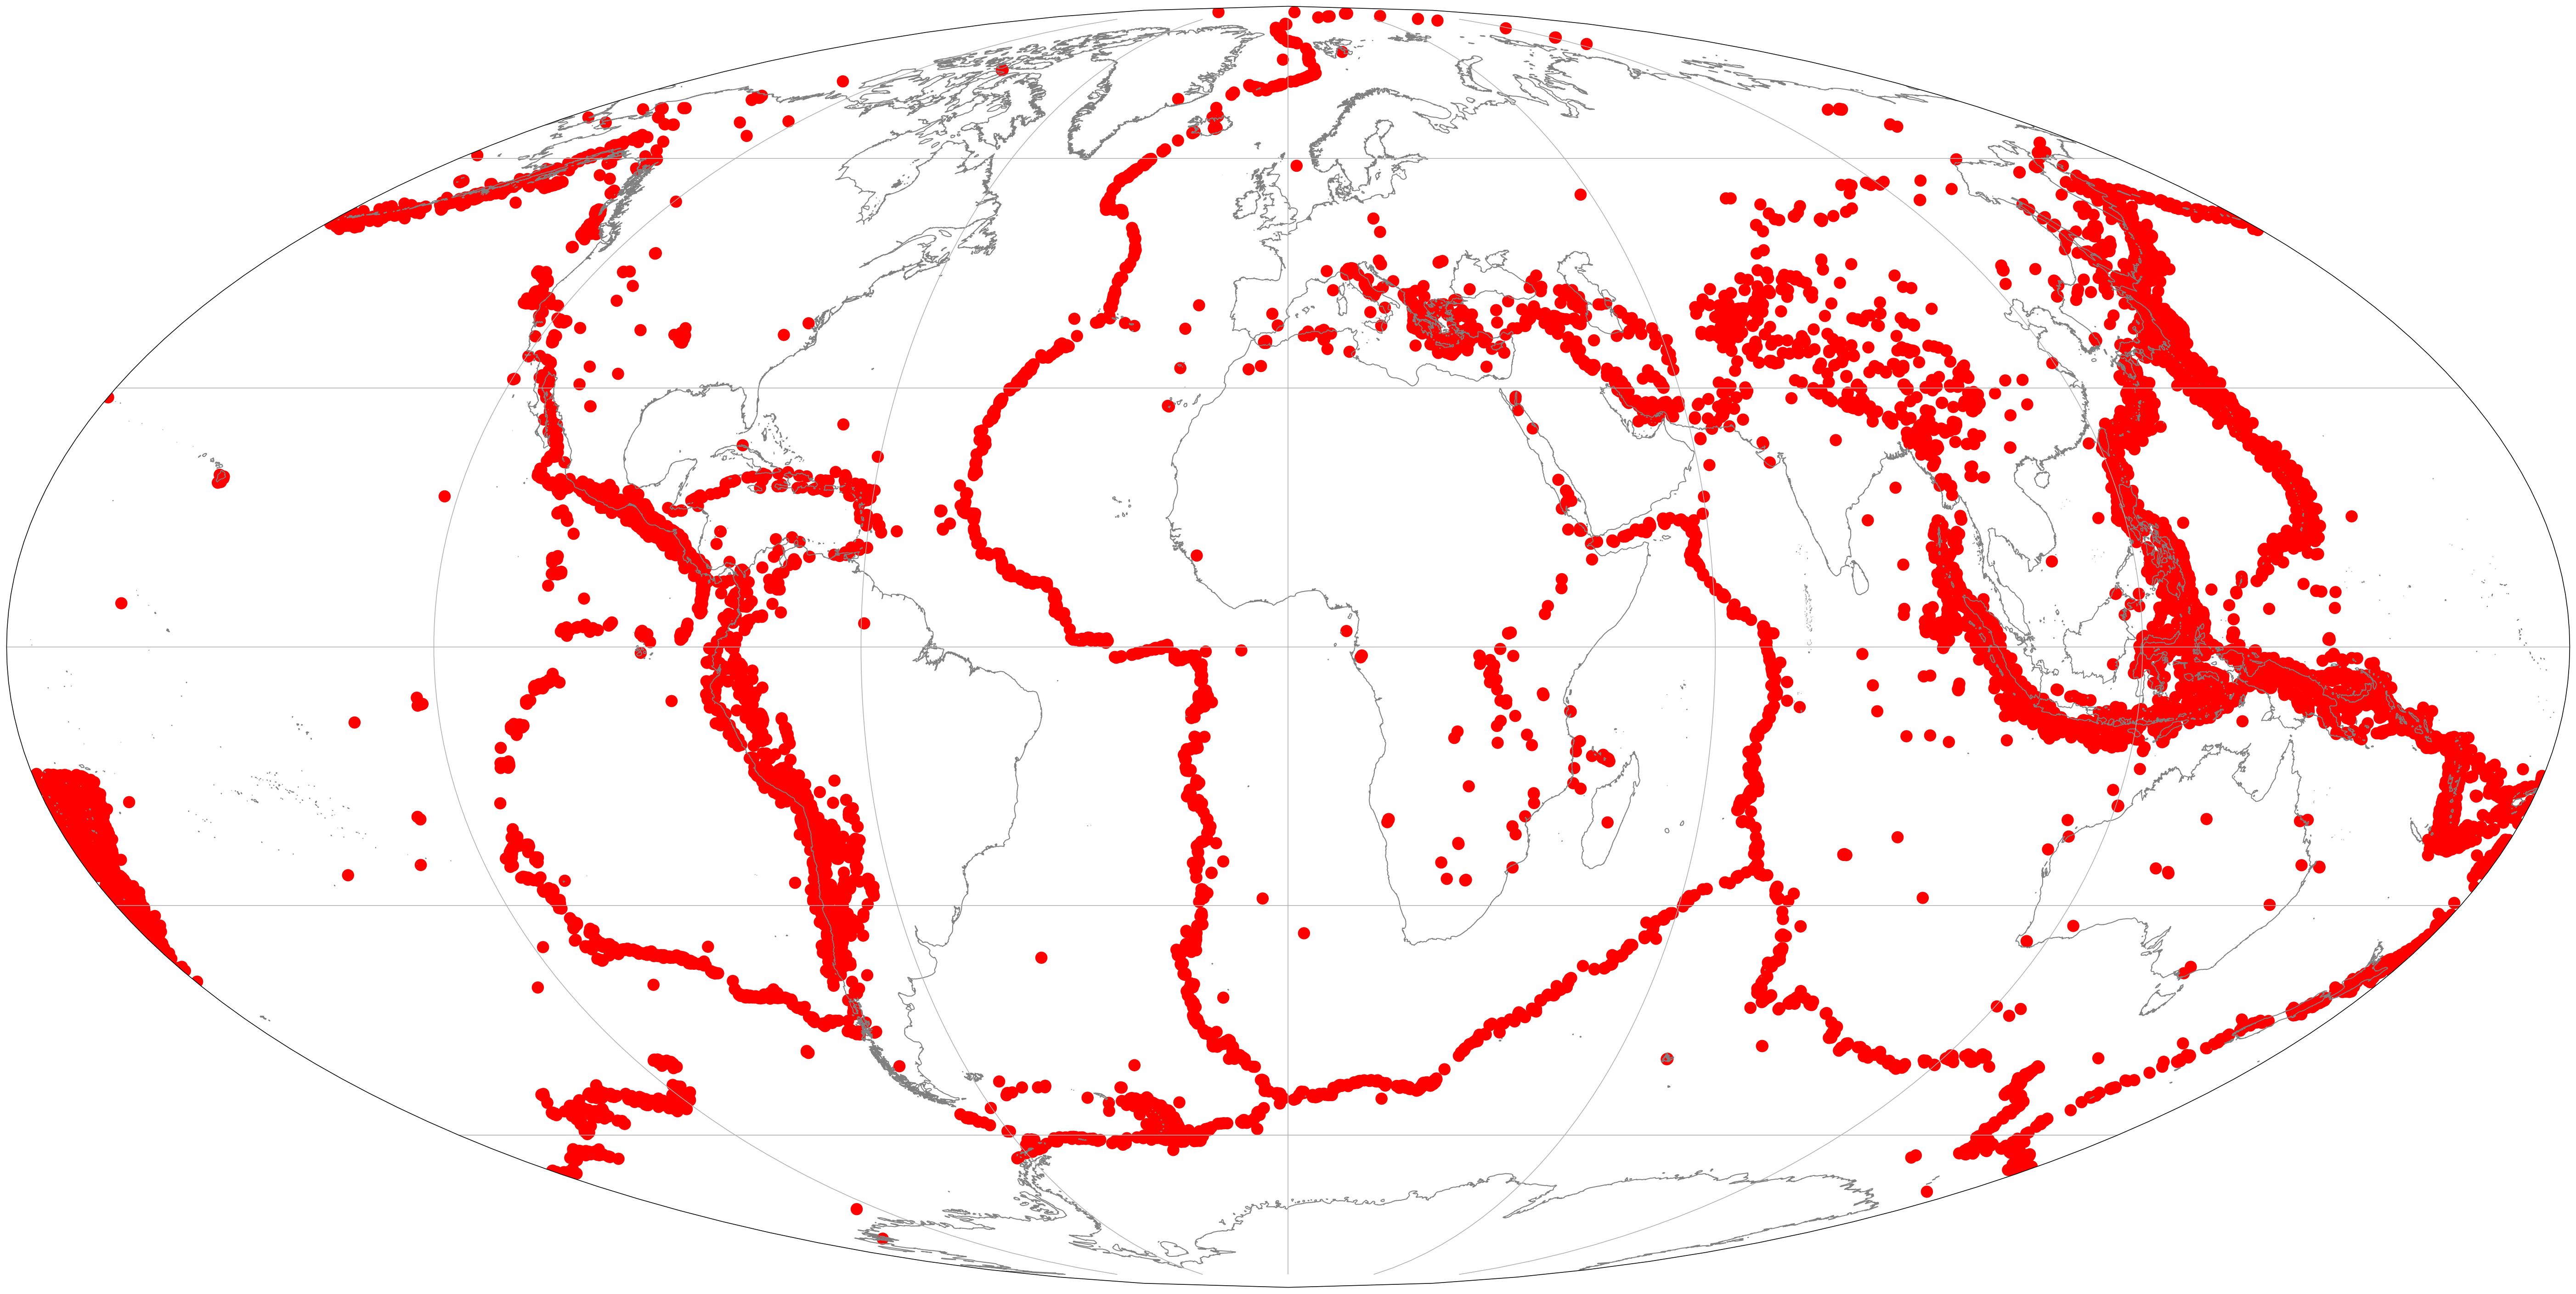

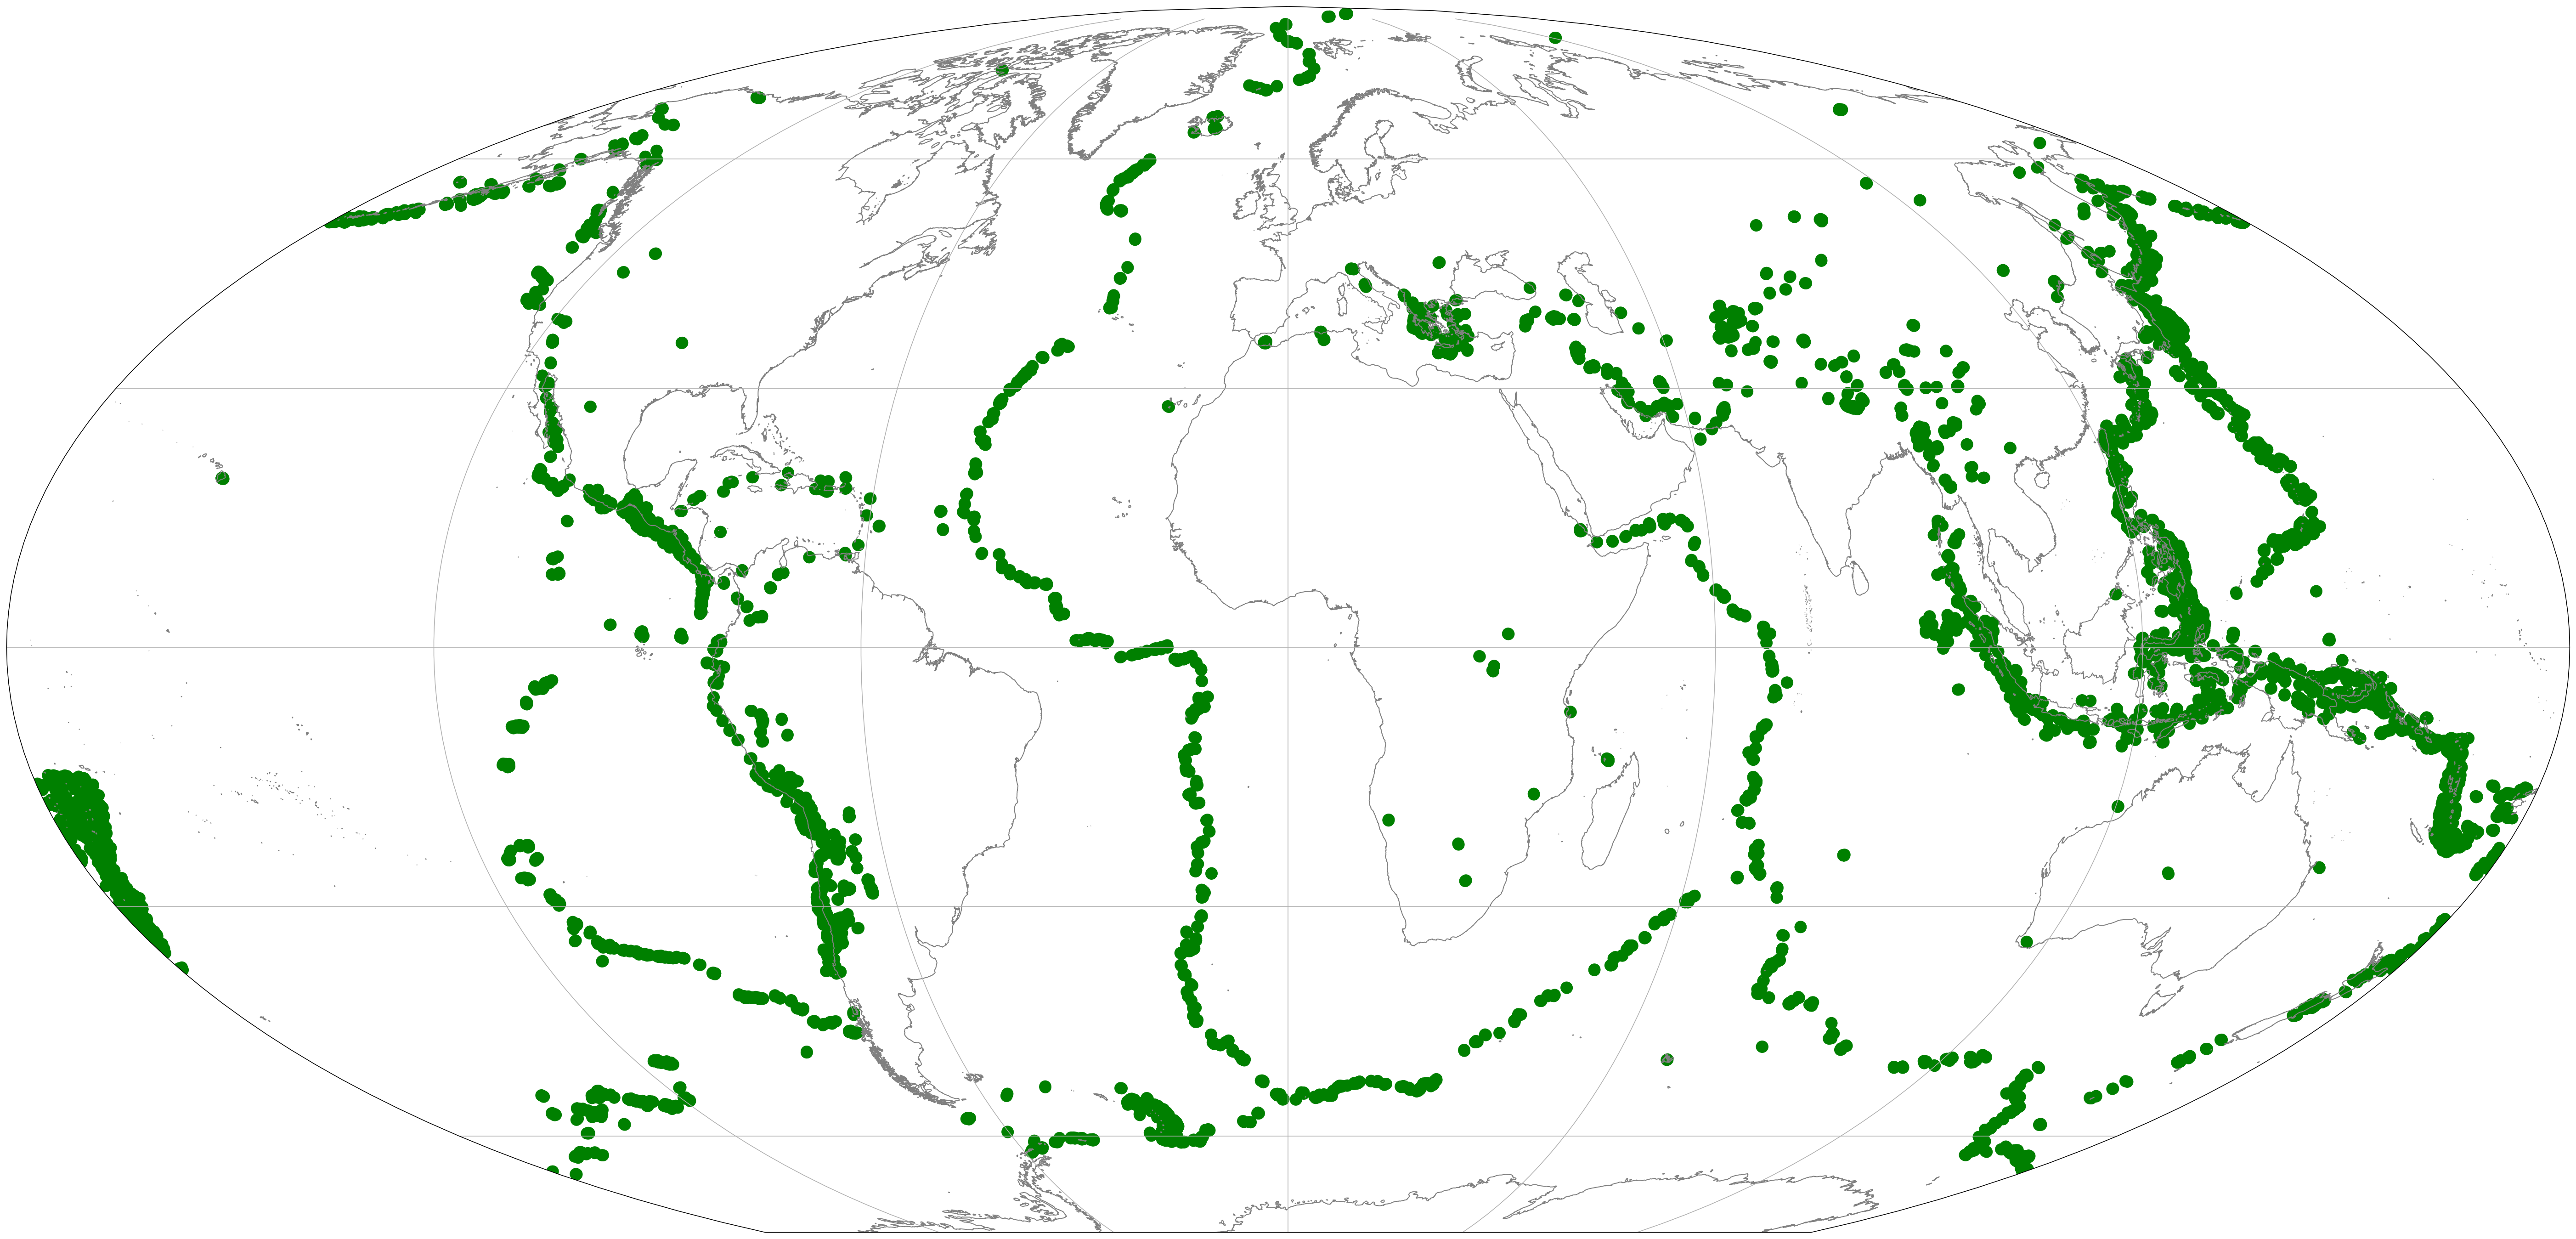

In [9]:
#Initial plate plotting using only EQ proximity
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(50,30))
graph = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = 0))
size= [[]] * len(evlat)
size[0].append(150)

events1 = graph.scatter(evlon, evlat, c='red', s=size, transform=ccrs.PlateCarree())
graph.coastlines(resolution='10m', color='gray')
graph.gridlines()
plt.show()

fig = plt.figure(figsize=(50,30))
graph2 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = 0))
size2= [[]] * len(keepLat)
size2[0].append(150)

events2 = graph2.scatter(keepLon, keepLat, c='green', s=size2, transform=ccrs.PlateCarree())
graph2.coastlines(resolution='10m', color='gray')
graph2.gridlines()    
plt.show()

## Eliminating outlying clusters
The initial plate plot using only proximity still had a fair number of outlying points. This section uses a cluster approach to select only those earthquakes with clusters of neighboring quakes.

In [10]:
def dist (x0,y0,x1,y1):
    R=6378
    diffLat=R*(x1-x0)*np.pi / 180
    diffLong=(R*np.cos(x1*np.pi / 180) * y1 * np.pi / 180) - (R*np.cos(x0*np.pi / 180) * y0 * np.pi / 180)

    distance=(np.sqrt(diffLat**2 + diffLong**2))
    return distance

In [11]:
#latkeep and lonkeep are array forms of the lats and lons extracted from 'keep', the list of indexes. 
print(len(keep))
latKeep=np.array(keepLat)
lonKeep=np.array(keepLon)
zero = np.zeros([1,len(latKeep)])
print(zero)
np.size(latKeep)

20413
[[ 0.  0.  0. ...,  0.  0.  0.]]


20413

In [12]:
#Store the lat and lons of earthquaes that meet the condition of distance < 500 and a cluster of > 10 
clusterLat=[]
clusterLon=[]
for event in range (len(keep)):
    centerLat=zero+latKeep[event]
    centerLon=zero+lonKeep[event]
    #print(centerLat[0],'lat')
    #print(centerLon[0],'lon')
    distance=dist(centerLat,centerLon,latKeep,lonKeep)
    #print(distance)
    cluster=np.sum(distance<=500)
    if cluster>10:
        clusterLat.append(latKeep[event])
        clusterLon.append(lonKeep[event])


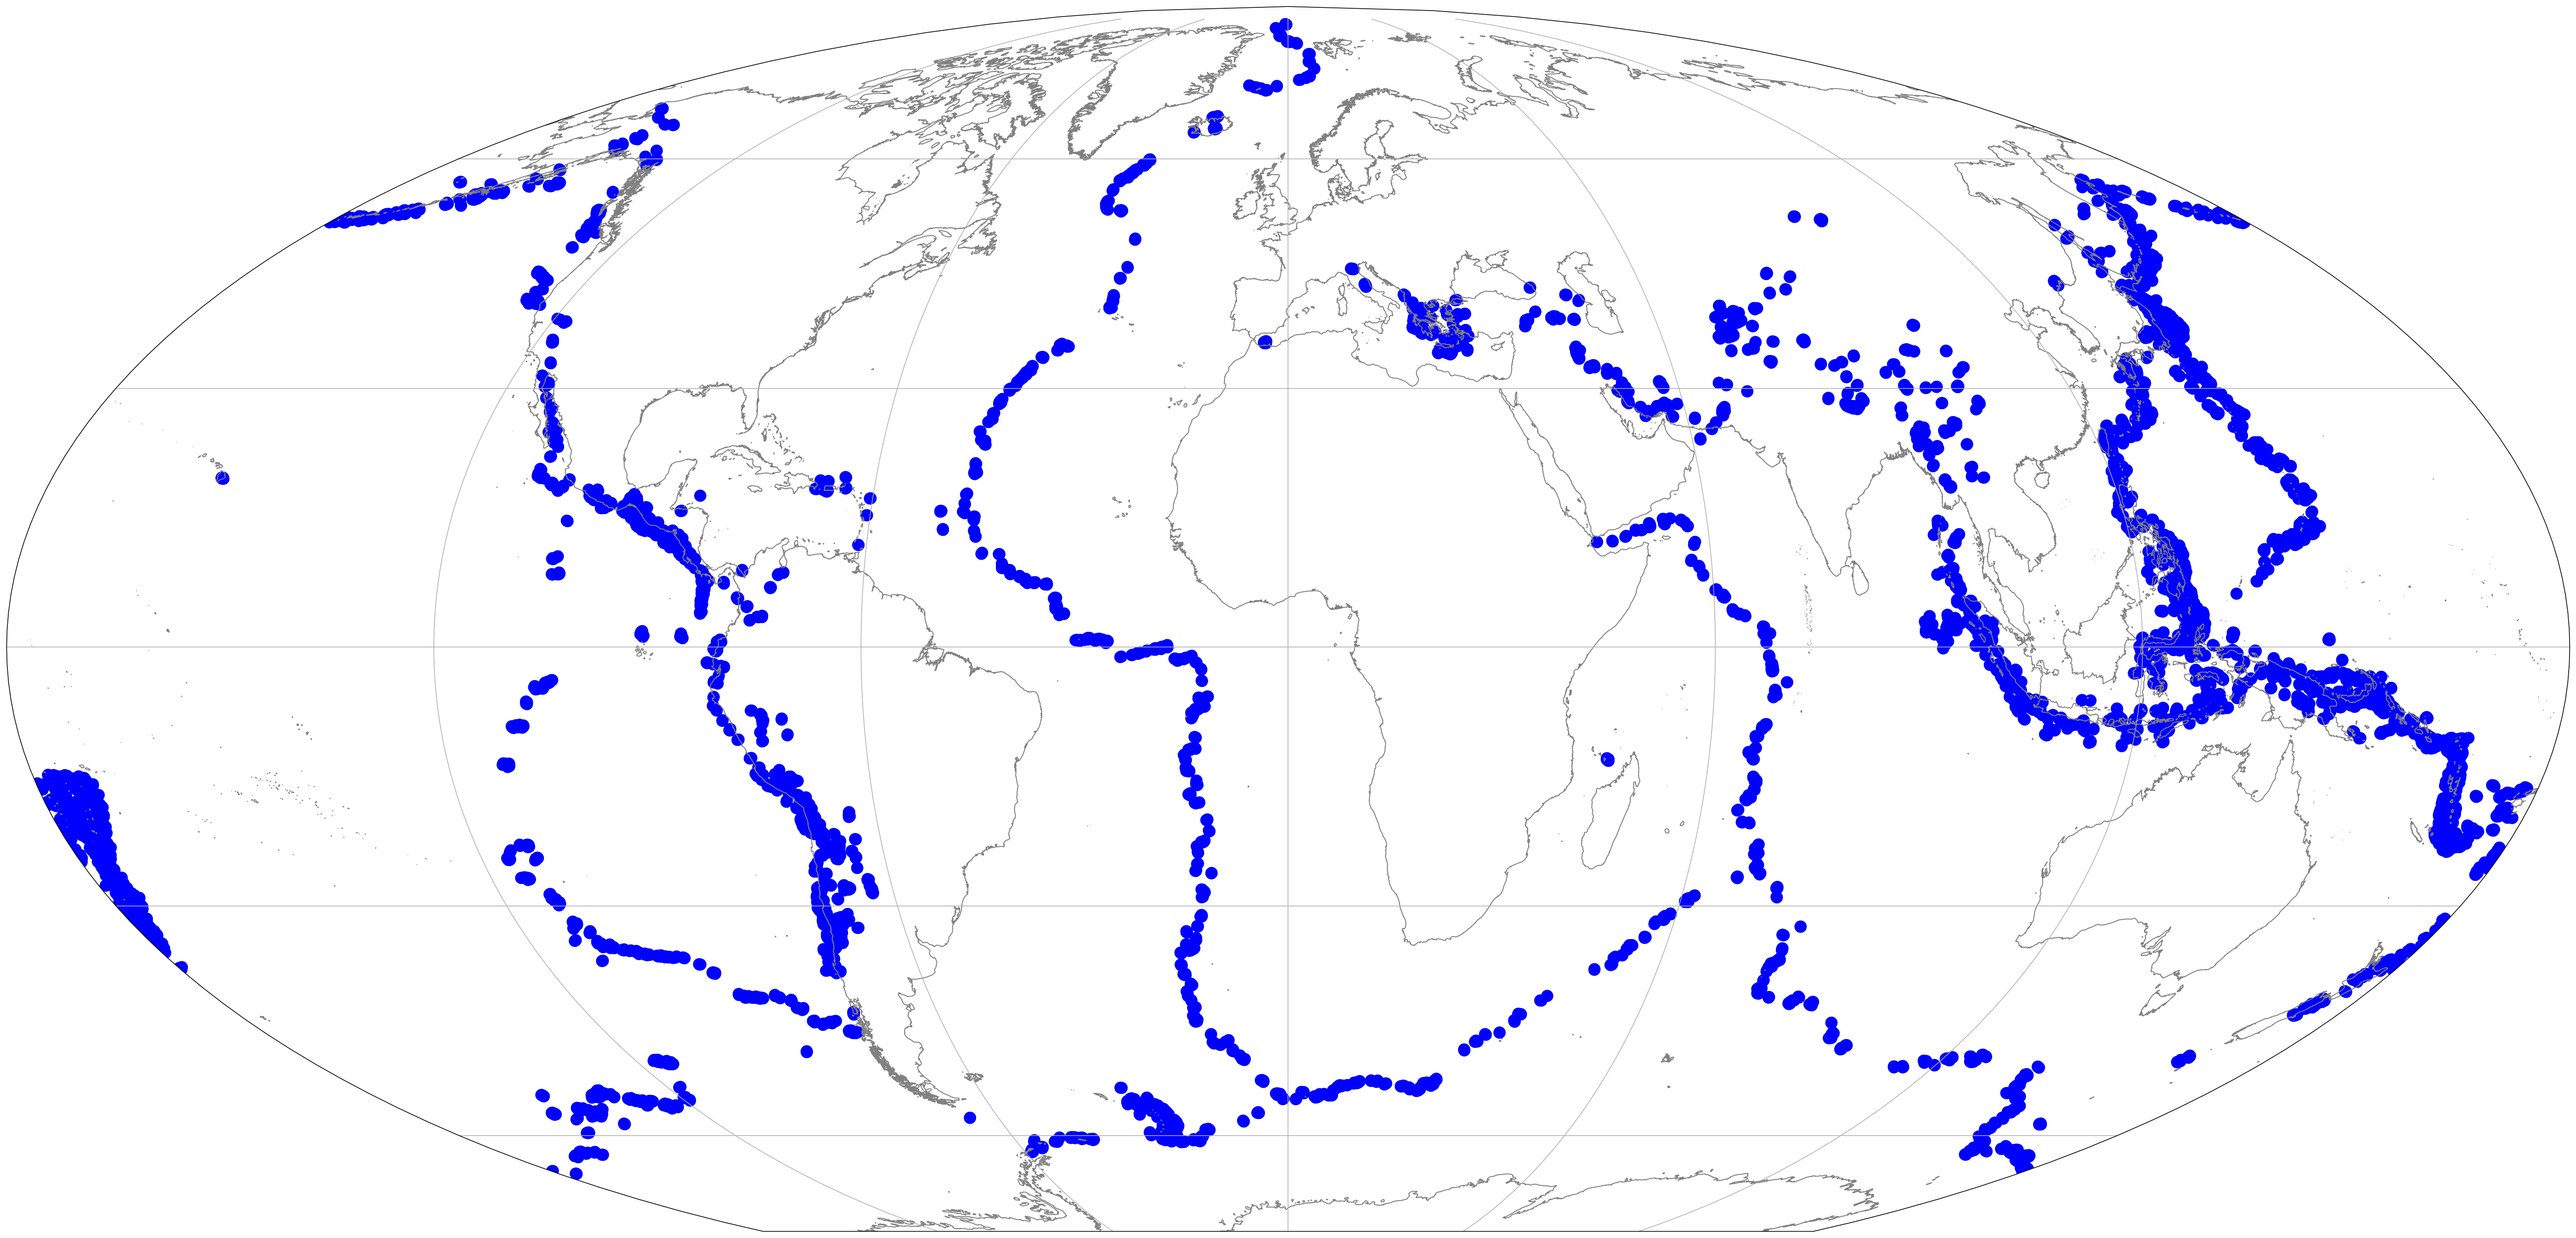

In [13]:
#Plotting Earthquakes that meet the cluster criteria. Much better. Many outlying quakes have been eliminated. 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(50,30))

graph = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = 0))


size= [[]] * len(clusterLon)
size[0].append(150)

events = graph.scatter(clusterLon, clusterLat, c='Blue', s=size, transform=ccrs.PlateCarree())
    
#Add coastlines and gridlines for lat/lon
graph.coastlines(resolution='10m', color='gray')
graph.gridlines()

plt.show()

## Animation code
-Altered version based on code from Rahul Kumar Singh: https://medium.com/analytics-vidhya/creating-map-animations-using-python-3b52061768a3

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib qt
%config InlineBackend.figure_format = 'retina'

currentDT = datetime.datetime.now()
print ('began: ',str(currentDT),'usually takes around 30 seconds')

lonPoints = clusterLon
latPoints= clusterLat
fig=plt.figure()
#mp stands for map
mp = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
mp.coastlines(resolution='10m', color='gray')
mp.gridlines()

#each call of the function plots the first 500 earthquakes in the list by their lat and lon, then clears those earthquakes out of the lists.
def animate(i):
    lonPlotting= lonPoints[0:0+500]
    latPlotting= latPoints[0:0+500]
    del lonPoints[0:0+500]
    del latPoints[0:0+500]
    mp.scatter(lonPlotting, latPlotting, color = 'blue', s=12, transform=ccrs.PlateCarree())
animation= FuncAnimation(fig, animate, frames=(len(clusterLat)//500), interval=200, repeat = False)
plt.show()
#animation.save('Animation.mp4', writer='ffmpeg')
currentDT = datetime.datetime.now()
print('done',str(currentDT))

began:  2021-11-30 15:26:07.266935 usually takes around 30 seconds
done 2021-11-30 15:26:44.531750


## Below is a comparison of different varietions of the cluster code to see which produces the most clear mapping of the plate boundaries. I selected cluster>10 and distance<=500

In [15]:
clusterLat=[]
clusterLon=[]
for event in range (len(keep)):
    centerLat=zero+latKeep[event]
    centerLon=zero+lonKeep[event]
    #print(centerLat[0],'lat')
    #print(centerLon[0],'lon')
    distance=dist(centerLat,centerLon,latKeep,lonKeep)
    #print(distance)
    cluster=np.sum(distance<=500)
    if cluster>10:
        clusterLat.append(latKeep[event])
        clusterLon.append(lonKeep[event])

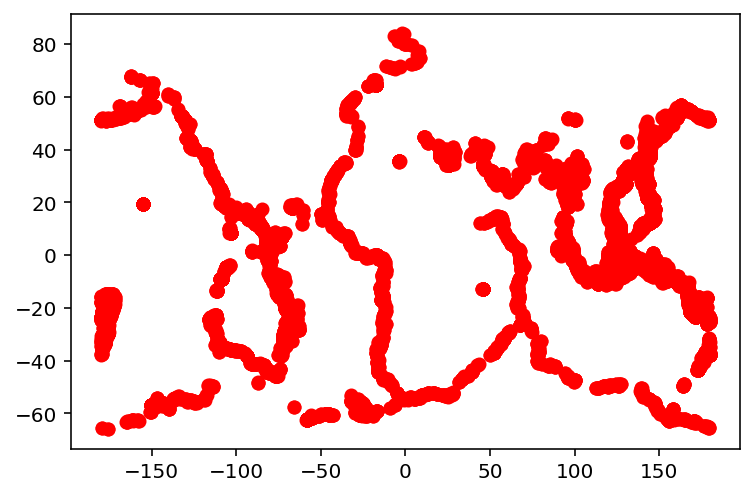

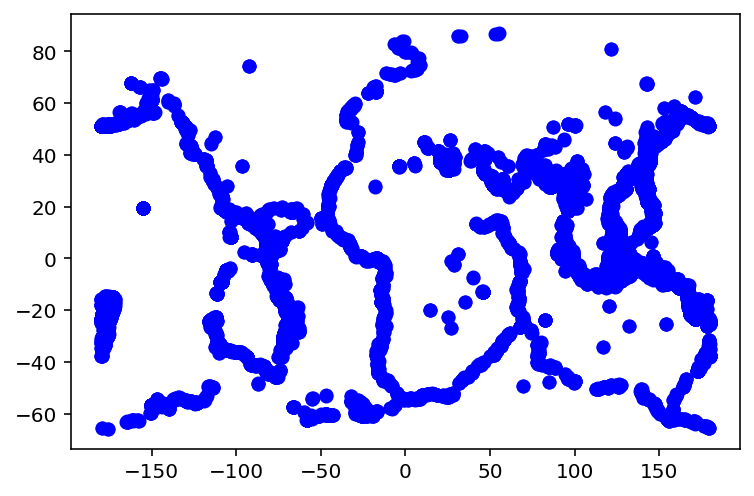

In [16]:
%matplotlib inline
plt.plot(clusterLon,clusterLat,'ro')
plt.show()
plt.plot(lonKeep,latKeep,'bo')
plt.show()
#dist=500, cluster10

In [17]:
clusterLat=[]
clusterLon=[]
for event in range (len(keep)):
    centerLat=zero+latKeep[event]
    centerLon=zero+lonKeep[event]
    #print(centerLat[0],'lat')
    #print(centerLon[0],'lon')
    distance=dist(centerLat,centerLon,latKeep,lonKeep)
    #print(distance)
    cluster=np.sum(distance<=100)
    if cluster>3:
        clusterLat.append(latKeep[event])
        clusterLon.append(lonKeep[event])

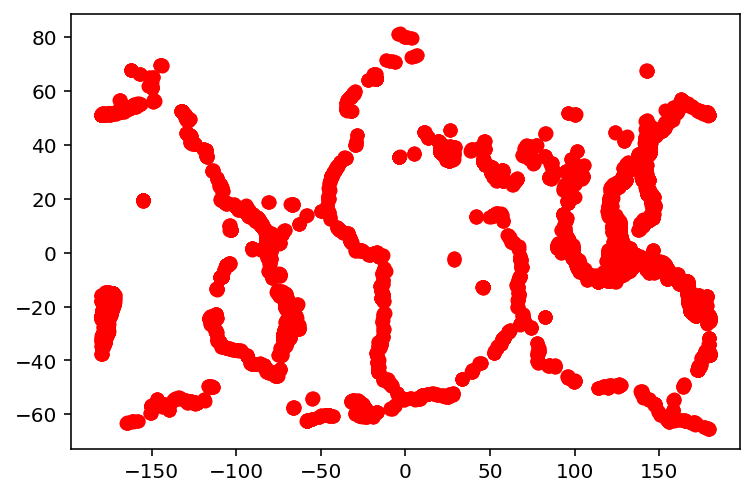

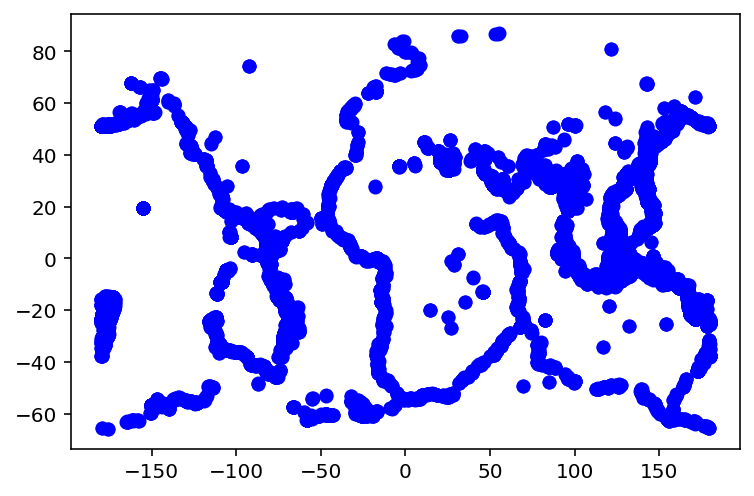

In [18]:
plt.plot(clusterLon,clusterLat,'ro')
plt.show()
plt.plot(lonKeep,latKeep,'bo')
plt.show()
#dist=100, cluster3

In [19]:
clusterLat=[]
clusterLon=[]
for event in range (len(keep)):
    centerLat=zero+latKeep[event]
    centerLon=zero+lonKeep[event]
    #print(centerLat[0],'lat')
    #print(centerLon[0],'lon')
    distance=dist(centerLat,centerLon,latKeep,lonKeep)
    #print(distance)
    cluster=np.sum(distance<=100)
    if cluster>5:
        clusterLat.append(latKeep[event])
        clusterLon.append(lonKeep[event])

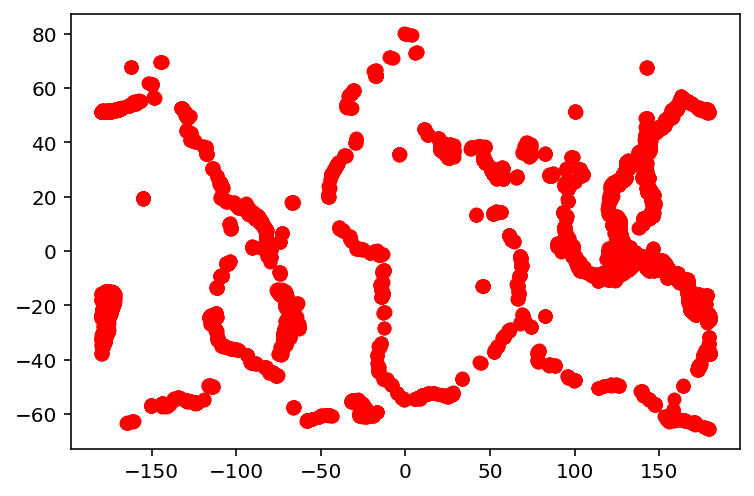

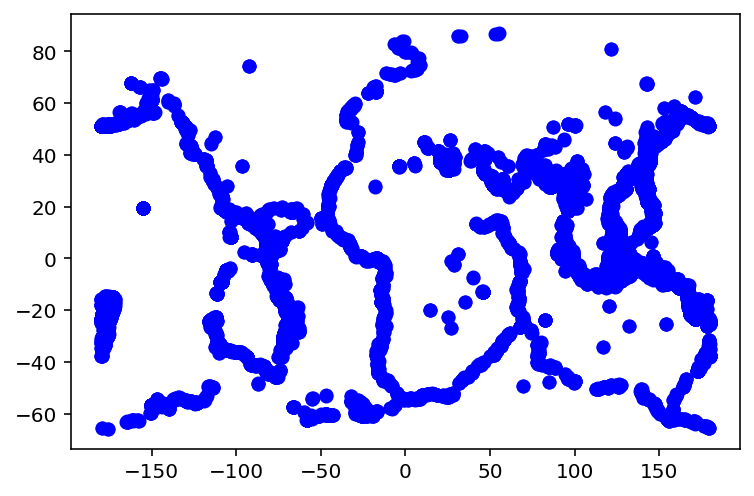

In [20]:
plt.plot(clusterLon,clusterLat,'ro')
plt.show()
plt.plot(lonKeep,latKeep,'bo')
plt.show()
#distance=100, cluster=5